# Preprocessing the VGKG Dataset

In [13]:
import sys
import urllib
import time
from gzip import GzipFile
import pandas as pd
import os
from ipywidgets import FloatProgress
from IPython.display import display
import re
from bs4 import BeautifulSoup
import nltk
import pickle
import gzip
import glob
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# ALWAYS import from dummy for I/O bound tasks
from multiprocessing.dummy import Pool as DummyPool
from multiprocessing import Pool

from util.download import webpage

## Initialization

In [14]:
# Global configuration variables
data_count = 5000 # The number of rows (=articles) to read 

# Read the first (of 7) parts of the dataset.
with GzipFile('data/GDELT_VGKG/vgkg-20160427-part1.csv.gz') as gzipfile:
    df = pd.read_csv(gzipfile, nrows=data_count)
    
df.head()

,DATE,DocumentIdentifier,ImageURL,RawJSON
0,20160307200000,http://sputniknews.com/us/20160307/1035926176/...,http://cdn2.img.sputniknews.com/images/103268/...,"{ ""responses"": [ { ""faceAnnotations"": [ { ""bou..."
1,20160318080000,http://sverigesradio.se/sida/artikel.aspx?prog...,http://sverigesradio.se/sida/images/1646/36601...,"{ ""responses"": [ { ""labelAnnotations"": [ { ""mi..."
2,20160318080000,http://www.ht.no/nyheter/2016/03/18/Legger-seg...,http://www.ht.no/incoming/article12288611.ece/...,"{ ""responses"": [ { ""labelAnnotations"": [ { ""mi..."
3,20160423200000,http://www.arabianewspaper.com/malayalam-news/...,http://www.arabianewspaper.com/media/selfie-pn...,"{ ""responses"": [ { ""labelAnnotations"": [ { ""mi..."
4,20160322080000,http://www.cronica.com.mx/notas/2016/951571.html,http://www.cronica.com.mx/nimagenes/4/2016-03-...,"{ ""responses"": [ { ""labelAnnotations"": [ { ""mi..."


## Articles

### 1) Download the raw HTML

In [6]:
%%time

f = FloatProgress(min=0, max=data_count)
display(f)
pool = DummyPool(8) # using dummypool here because for whatever reason the other one doesn't get proper bandwidth
results = list()
for result in pool.imap(webpage.download_and_save, df.iterrows()):
    f.value += 1
    results.append(result)
pool.close()
pool.join()

FloatProgress(value=0.0, max=1000.0)

CPU times: user 20.8 s, sys: 3.72 s, total: 24.5 s
Wall time: 4min 23s


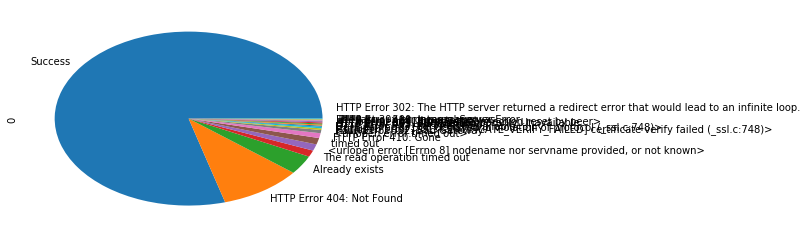

In [8]:
pd.DataFrame(results)[0].value_counts().plot.pie()

### 2) Extract sentences
Useful for RNN approaches to sentence encoding

In [2]:
files = glob.glob("data/GDELT_VGKG/articles/raw/[0-9]*")
f = FloatProgress(min=0, max=len(files))
display(f)
pool = Pool(20)
results = list()
for result in pool.imap(webpage.extract_sentences_and_save, files):
    f.value += 1
    results.append(result)
pool.close()
pool.join() 

FloatProgress(value=0.0, max=539.0)

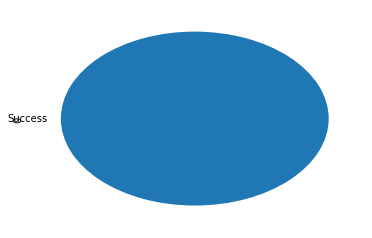

In [3]:
pd.DataFrame(results)[0].value_counts().plot.pie()

In [12]:
lengths = list()
files = glob.glob("data/GDELT_VGKG/articles/sentences/[0-9]*")
for file in files:
    with gzip.open(file, "rb") as f:
            doc = pickle.load(f)
            lengths.append((file, len(doc)))
            
df = pd.DataFrame(lengths, columns=["File","Length"])
df.sort_values("Length", ascending=False).head()

,File,Length
53,data/GDELT_VGKG/articles/sentences/20160220084500,983
146,data/GDELT_VGKG/articles/sentences/20160302143000,707
281,data/GDELT_VGKG/articles/sentences/20160322133000,559
289,data/GDELT_VGKG/articles/sentences/20160323114500,458
504,data/GDELT_VGKG/articles/sentences/20160422080000,448


In [7]:
df[df["DATE"] == 20160220084500].iloc[0].DocumentIdentifier

'http://www.murmansk.kp.ru/online/news/2312997/'

In [47]:
file_to_unzip = "20160328063000"
with gzip.open("data/GDELT_VGKG/articles/raw/%s" % file_to_unzip, "rb") as infile:
    doc = pickle.load(infile)
    with open("data/GDELT_VGKG/articles/unzipped/%s.html" % file_to_unzip, "wb+") as outfile:
        outfile.write(doc)
        outfile.close()

In [ ]:
plt.hist(lengths)
plt.show()

### 3 ) Filter language to only english

In [15]:
# For now let's just look at the languages
files = glob.glob("data/GDELT_VGKG/articles/sentences/[0-9]*")
f = FloatProgress(min=0, max=len(files))
display(f)
pool = Pool(8)
results = list()
for result in pool.imap(webpage.save_if_english, files):
    f.value += 1
    results.append(result)
pool.close()
pool.join() 

FloatProgress(value=0.0, max=539.0)

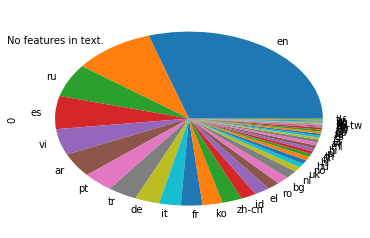

In [16]:
pd.DataFrame(results)[0].value_counts().plot.pie()

In [17]:
lengths = list()
files = glob.glob("data/GDELT_VGKG/articles/sentences_english/[0-9]*")
for file in files:
    with gzip.open(file, "rb") as f:
            doc = pickle.load(f)
            lengths.append((file.split("/")[-1], len(doc)))
            
df = pd.DataFrame(lengths, columns=["File","Length"])
df.sort_values("Length", ascending=False).head()

,File,Length
15,20160220084500,91843
117,20160405161500,24936
54,20160308074500,16217
18,20160221183000,14220
128,20160411124500,13815


##  Images
### 1) Download the raw images

In [ ]:
     
# TODO create number of URLS (including splitting by error type) 
# and Number of average Characters at each stage plots
# TODO look into the errors in more detail (especially 403's etc.)
# TODO store and publicise raw html/preprocessed/images
# TODO some articles only contain very few words for some reason. Figure out what to do about that.

### Yolo

In [3]:
%%time

dataset_time = 1535141748 # set this to which version of the collected data is to be used
image_path = "data/GDELT_VGKG/preprocessed/images/%d/" % dataset_time
image_classification_path = "data/GDELT_VGKG/preprocessed/image_classifications/yoloV3-tiny/%d/%d/" % (dataset_time, time.time())
# TODO make the testing of different classifiers DRY

os.makedirs(image_classification_path)

sys.path += [os.getcwd()]
os.environ['DYLD_LIBRARY_PATH'] = "/usr/local/cuda/lib"
%run darknet_wrapper.py

MODEL="yolov3-tiny"
net, meta = initialize_classifier(config="cfg/%s.cfg"%MODEL, weights="weights/%s.weights"%MODEL, data="cfg/coco.data")

images = os.listdir(image_path)
f = FloatProgress(min=0, max=len(images))
display(f)
for image in images:
    f.value += 1
    try:
        image_dir = image_path + "/" + image
        result = detect(net, meta, image_dir)
        labels = dict()
        for label, probability, coordinates in result:
            if label in labels: 
                labels[label]+=1 
            else:
                labels[label] = 1
        # Save classification result
        file = open("%s/%s" % (image_classification_path, image), "wb+")
        pickle.dump(labels, file)
        
    except Exception as e:
            print(e)
            # Some of the files are not actually images


/usr/local/cuda/lib


FloatProgress(value=0.0, max=41.0)

{}
{b'person': 5}
{}
{b'person': 3, b'tie': 1}
{b'person': 1}
{b'person': 1}
{}
{b'person': 1}
{b'person': 2}
{b'person': 2}
{b'person': 3, b'chair': 1}
{b'person': 3}
{b'person': 2}
{}
{b'person': 1}
{}
{}
{}
{}
{b'person': 1}
{b'person': 4}
{}
{b'person': 1}
{}
{}
{b'car': 3}
{b'person': 2}
{b'person': 1}
{b'person': 2}
{b'person': 1, b'bicycle': 1}
{}
{b'person': 3}
{}
{}
{}
{b'person': 1}
{b'person': 1}
{b'tie': 1}
{}
{b'person': 2}
{b'person': 1}
CPU times: user 4.44 s, sys: 450 ms, total: 4.89 s
Wall time: 5.72 s


### Mask R-CNN

#### Loading the Classifier and the Images

In [29]:
sys.path += [os.getcwd() + "/Mask_RCNN", os.getcwd(), os.getcwd() + "/Mask_RCNN/samples/coco/"]
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
import coco

MODEL_DIR="Mask_RCNN/logs"
COCO_MODEL_PATH="Mask_RCNN/mask_rcnn_coco.h5"

DETECTION_THRESHOLD = .5 # .5 is the default threshold of YOLO so we're using that here as well

dataset_time = 1535141748 # set this to which version of the collected data is to be used
image_path = "data/GDELT_VGKG/preprocessed/images/%d/" % dataset_time
image_classification_path = "data/GDELT_VGKG/preprocessed/image_classifications/maskrcnn/%d/%d/" % (dataset_time, time.time())
# TODO make the testing of different classifiers DRY

os.makedirs(image_classification_path)

image_names = os.listdir(image_path)[:10]

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = len(images)

config = InferenceConfig()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

#### Classifiying the images

In [30]:
%%time
import skimage

try:
    images = [skimage.io.imread(image_path + "/" + image) for image in image_names]
    results = model.detect(images, verbose=1)
except Exception as e:
        print(e)
        # Some of the files are not actually images


Processing 10 images
image                    shape: (346, 607, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (324, 576, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (360, 420, 3)         min:   85.00000  max:  255.00000  uint8
image                    shape: (551, 600, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (699, 306, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (400, 581, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (337, 598, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (409, 600, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (720, 1200, 3)        min:    0.00000  max:  255.00000  uint8
image                    shape: (466, 965, 3)         min:    0.00000  max:  255.00000  uint8


/Users/claasmeiners/.virtualenvs/Thesis/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


molded_images            shape: (10, 1024, 1024, 3)   min: -123.70000  max:  151.10000  float64
image_metas              shape: (10, 93)              min:    0.00000  max: 1200.00000  float64
anchors                  shape: (10, 261888, 4)       min:   -0.35390  max:    1.29134  float32
CPU times: user 14min 41s, sys: 32.8 s, total: 15min 13s
Wall time: 2min 7s


### Saving the results 

In [41]:
# Bring the results into the same format 
index = 0
for result in results:
    labels = dict()
    for class_id, score in zip(result['class_ids'],result['scores']):
        if score > DETECTION_THRESHOLD:
            label = class_names[int(class_id)]
            if label in labels: 
                labels[label]+=1 
            else:
                labels[label] = 1
    print(image_names[index] + ": " + str(labels))
    # Save classification result
    file = open("%s/%s" % (image_classification_path, image), "wb+")
    pickle.dump(labels, file)
    index += 1

20160213120000: {'person': 2, 'bicycle': 1}
20160215040000: {'person': 7, 'tie': 1, 'potted plant': 1}
20160215200000: {'person': 2}
20160218080000: {'person': 8, 'tie': 3}
20160219200000: {'person': 1, 'car': 1, 'handbag': 1}
20160220234500: {'tie': 1, 'person': 18}
20160222080000: {'clock': 1}
20160223040000: {'person': 1}
20160223200000: {'person': 1}
20160229120000: {'person': 5}


## Search Language inconsistencies / hard to classify languages